# Podstawowe algorytmy kwantowe w Qiskit

In [14]:
from typing import Callable, Iterable, NewType, Tuple
import qiskit as qs
from qiskit.circuit import Gate
from qiskit.circuit.library import MCMTGate, ZGate
import numpy as np
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

def plot_counts(counts: dict, ax: Axes):
    ax.bar(list(counts.keys()), list(counts.values()))

# TODO dodać wstęp - notacja, teoria informatyki kwantowej

## Algorytm Deutsch'a-Jozs'y
### Problem
Dana jest funkcja $f:\{0, 1\}^n \rightarrow \{0, 1\}$. Funkcja może być:
 - Stała: dla każdego $\{0, 1\}^n$ zwraca $0$ lub $1$ 
 - Zbalansowana: dla połowy $\{0, 1\}^n$ zwraca $0$, dla drugiej $1$


Algorytm Deutsch'a-Jozs'y odpowiada na pytanie czy $f$ jest stała, czy zbalansowana.

### Podejście klasyczne
- Najlepszy przypadek: pierwsze dwa zawołania $f$ zwracają różne wartości $\rightarrow$ $f$ jest zbalansowana
- Najgorszy przypadek: pierwsze $2^{n-1}$ zawołań $f$ zwraca tą samą wartość, dopiero przy $2^{n-1}+1$ zawołaniu zwracana jest
     - ta sama wartość co wcześniej $\rightarrow$ $f$ jest stała
     - inna wartość niż wcześniej $\rightarrow$ $f$ jest zbalansowana

In [15]:

OracleType = NewType('OracleType', int)
ORACLE_CONST_0 = OracleType(0)
ORACLE_CONST_1 = OracleType(1)
ORACLE_BALANCED = OracleType(2)

backend = AerSimulator()
n = 3

In [16]:
def dj_oracle_generate(oracle_type: OracleType, n: int) -> Tuple[qs.QuantumCircuit, Gate]:
    oracle = qs.QuantumCircuit(n+1)

    if oracle_type == ORACLE_CONST_0:
        pass

    elif oracle_type == ORACLE_CONST_1:
        oracle.x(range(n))

    elif oracle_type == ORACLE_BALANCED:
        def add_cx(state : int) -> None:
            for qubit, cbit in enumerate(reversed(f"{state:0b}")):
                if cbit == '1':
                    oracle.x(qubit)
        
        one_states = np.random.choice(range(2**n), size=2**(n-1), replace=False)
        for state in one_states:
            add_cx(state)
            oracle.mcx(list(range(n)), n)
            add_cx(state)

    oracle_gate = oracle.to_gate()
    oracle_gate.name = f"Oracle"

    return oracle, oracle_gate

### Wyrocznia zbalansowana

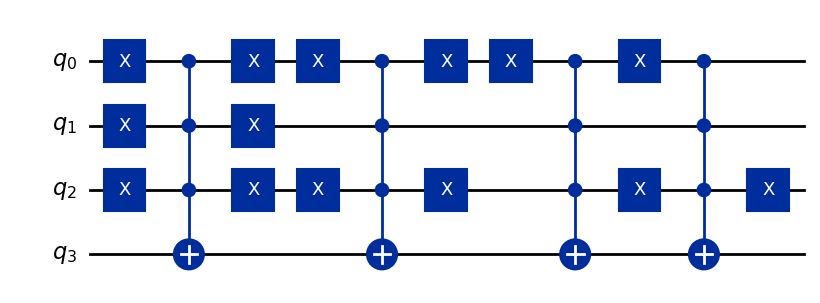

In [17]:
dj_oracle_balanced, dj_oracle_balanced_gate = dj_oracle_generate(ORACLE_BALANCED, n)
dj_oracle_balanced.draw('mpl')

### Wyrocznia stała

#### Stała 0

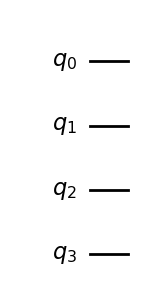

In [18]:
dj_oracle_const_0, dj_oracle_const_0_gate = dj_oracle_generate(ORACLE_CONST_0, n)
dj_oracle_const_0.draw('mpl')

#### Stała 1

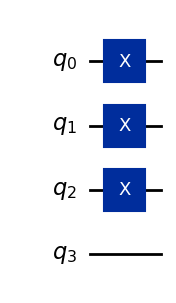

In [19]:
dj_oracle_const_1, dj_oracle_const_1_gate = dj_oracle_generate(ORACLE_CONST_1, n)
dj_oracle_const_1.draw('mpl')

### Algorytm
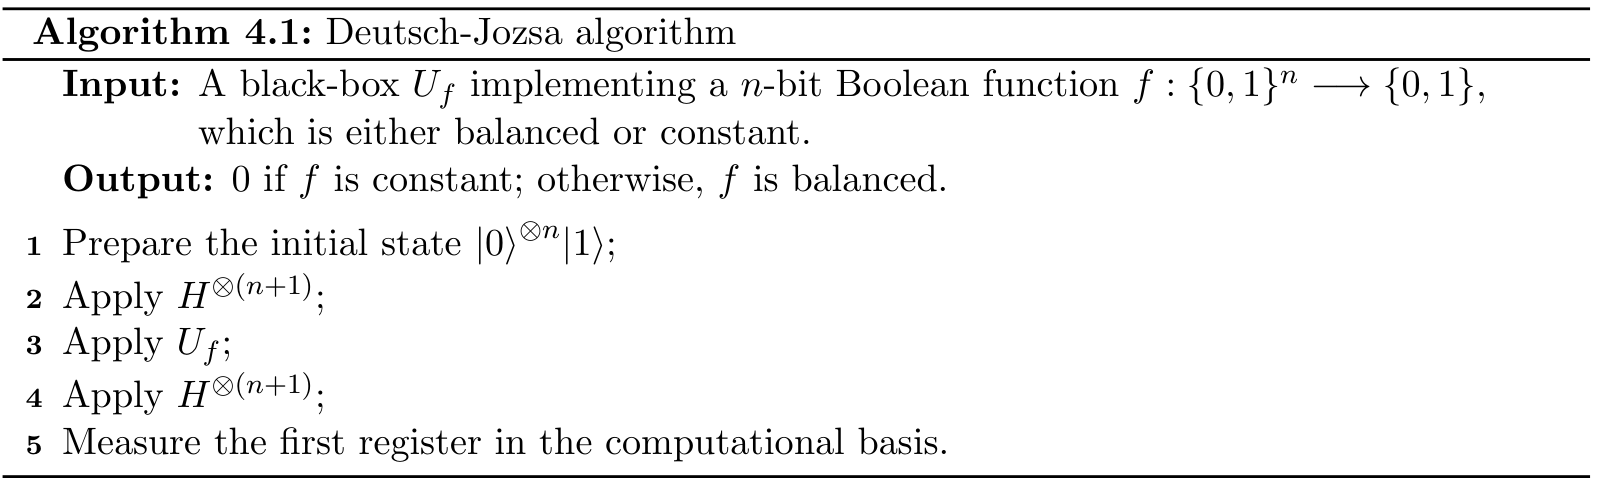


In [20]:
def dj_algorithm_circuit_generate(oracle: Gate | qs.QuantumCircuit, n: int) -> qs.QuantumCircuit:
    dj_circuit = qs.QuantumCircuit(n+1, n)
    dj_circuit.x(n)
    dj_circuit.h(range(n+1))
    dj_circuit.append(oracle, range(n+1))
    dj_circuit.h(range(n))
    dj_circuit.measure(range(n), range(n))

    return dj_circuit

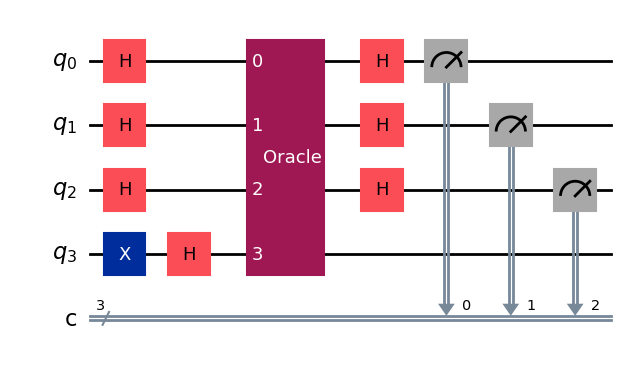

In [21]:
dj_circuit_balanced = dj_algorithm_circuit_generate(dj_oracle_balanced_gate, n)
dj_circuit_balanced.draw('mpl')

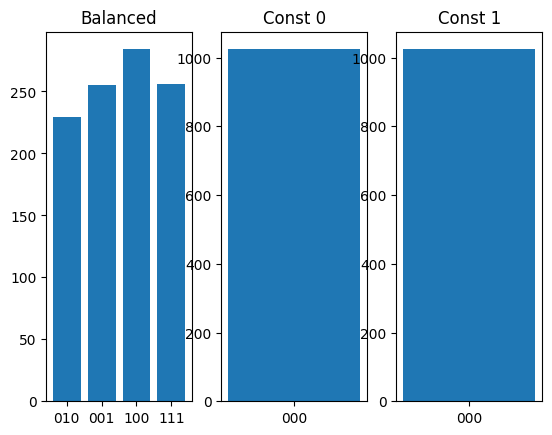

In [22]:
dj_circuit_balanced_transpiled = qs.transpile(dj_circuit_balanced, backend)
dj_circuit_const_0_transpiled = qs.transpile(dj_algorithm_circuit_generate(dj_oracle_const_0_gate, n), backend)
dj_circuit_const_1_transpiled = qs.transpile(dj_algorithm_circuit_generate(dj_oracle_const_1_gate, n), backend)
counts_balanced = backend.run(dj_circuit_balanced_transpiled, shots=1024).result().get_counts()
counts_const_0 = backend.run(dj_circuit_const_0_transpiled, shots=1024).result().get_counts()
counts_const_1 = backend.run(dj_circuit_const_1_transpiled, shots=1024).result().get_counts()


fig, ax = plt.subplots(1, 3)
ax[0].set_title('Balanced')
ax[1].set_title('Const 0')
ax[2].set_title('Const 1')

plot_counts(counts_balanced, ax[0])
plot_counts(counts_const_0, ax[1])
plot_counts(counts_const_1, ax[2])


## Algorytm Grover'a
### Problem
Dana jest funkcja $f$, gdzie 
- $N = 2^n$
- $f:\{0,\ldots,N-1\} \rightarrow \{0, 1\}$
- $f(x)=1 \iff x = x_0$, czyli $f(x)=1$ jeśli $x=x_0$, w innych przypadkach $f(x)=0$
- $x_0$ może być wiele

Algorytm Grover'a znajduje $x_0$.

### Podejście klasyczne
Najlepszy przypadek: pierwsze zawołanie $f$ zwraca $1$


Najgorszy przypadek: $N$-te zawołanie $f$ zwraca $1$ 


In [23]:
n = 3

In [45]:
def grover_oracle_generate(n : int, marked_states: list) -> Tuple[qs.QuantumCircuit, Gate]:
    oracle = qs.QuantumCircuit(n)

    for state in marked_states:
        state_str = f"{state:0{n}b}"[::-1]
        if len(state_str) > n:
            raise ValueError()
        
        zeros = [zero for zero, val in enumerate(state_str) if val == '0']
        oracle.x(zeros)
        oracle.append(MCMTGate(ZGate(), n - 1, 1), range(n))
        oracle.x(zeros)
    
    oracle_gate = oracle.to_gate()
    oracle_gate.name = 'Oracle'

    return oracle, oracle_gate

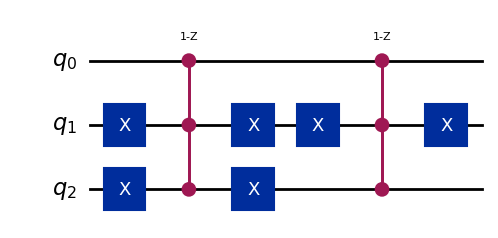

In [79]:
marked_states = [1, 5]
grover_oracle, grover_oracle_gate = grover_oracle_generate(n, marked_states)

grover_oracle.draw('mpl')

In [85]:
def grover_base_generate(oracle: Gate, n : int) ->  Tuple[qs.QuantumCircuit, Gate]:
    grover_op_circuit = qs.QuantumCircuit(n)
    grover_op_circuit.append(oracle, range(n))
    
    # Grover diffusion operator
    grover_op_circuit.h(range(n))
    grover_op_circuit.x(range(n))
    grover_op_circuit.append(MCMTGate(ZGate(), n - 1, 1), range(n))
    grover_op_circuit.x(range(n))
    grover_op_circuit.h(range(n))
    
    grover_op_gate = grover_op_circuit.to_gate()
    grover_op_gate.name = 'Grover'

    return grover_op_circuit, grover_op_gate

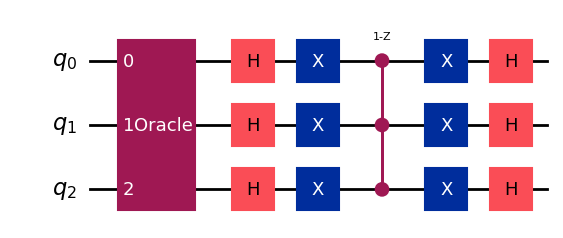

In [49]:
grover_op_circuit, _ = grover_base_generate(grover_oracle_gate, n)
grover_op_circuit.draw('mpl')

In [60]:
def grover_algorithm_circuit_generate(oracle: Gate, n : int) -> Tuple[qs.QuantumCircuit, int]:
    grover_circuit = qs.QuantumCircuit(n, n)
    grover_circuit.h(range(n))

    grover_op_circuit, grover_op_gate = grover_base_generate(oracle, n)
    
    iterations = int(np.pi / 4 * np.sqrt(2**n / len(marked_states)))
    grover_circuit.append(grover_op_gate.power(iterations), range(n))

    grover_circuit.measure(range(n), range(n))
    
    return grover_circuit, iterations


Iterations: 1


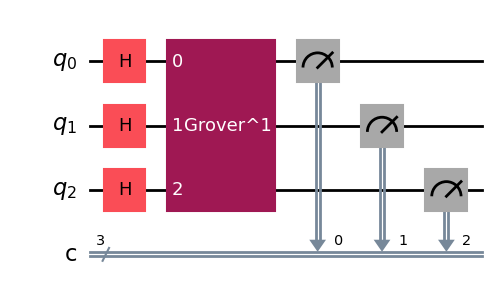

In [87]:
grover_algorithm_circuit, iterations = grover_algorithm_circuit_generate(grover_oracle_gate, n)
print(f"Iterations: {iterations}")
grover_algorithm_circuit.draw("mpl")

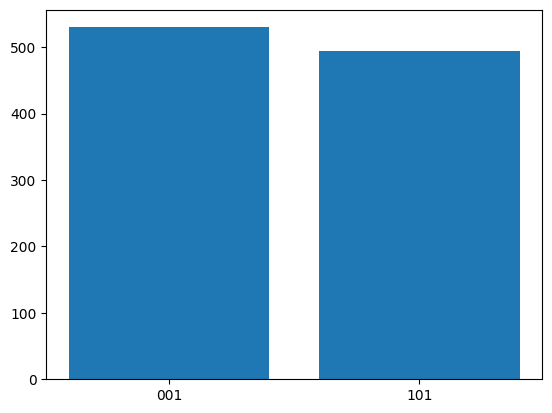

In [88]:
grover_circuit_transpiled = qs.transpile(grover_algorithm_circuit, backend)
counts_grover = backend.run(grover_circuit_transpiled, shots=1024).result().get_counts()

fig, ax = plt.subplots(1)
# ax[0].set_title('Balanced')

plot_counts(counts_grover, ax)